In [1]:
from tokenizers import TRIETokenizer
import torch
from torch import nn
import numpy as np
import tqdm.notebook as tqdm
import time
import bisect
from typing import *
import gc
from dataclasses import dataclass
from flash_attn import flash_attn_func
from flash_attn_triton import flash_attn_func as flash_attn_func_triton
from dataloader import DatasetReader, DatasetIter, SingleDatasetReader, MultiDatasetsReader
from math import ceil
from functools import partial
from matplotlib import pyplot as plt
import bitsandbytes as bnb
from threading import Lock, Thread
import traceback
import json
import pickle
import os
from enum import Enum
from modeling import *

In [2]:
g_tokenizer = TRIETokenizer('llama_vocab_pruned_32k.json')

In [3]:
# Network definition
C_SEQ_LEN = 2048
C_HIDDEN_SIZE = 768
C_NUM_HEADS = 12
C_NUM_LAYERS = 12

C_DEVICE = torch.device('cuda')
C_DTYPE = torch.bfloat16

C_DEBUG = False

In [4]:
if not C_DEBUG:
    # g_train_data = MultiDatasetsReader([
    #     SingleDatasetReader('datasets/minipile_train.bin'),
    #     SingleDatasetReader('datasets/enwiki_train.bin'),
    #     SingleDatasetReader('datasets/tinytextbooks_train.bin'),
    # ], seed=0)
    g_train_data = MultiDatasetsReader([
        SingleDatasetReader('datasets/tinystories_train_masked.bin'),
    ], seed=0)
else:
    g_train_data = MultiDatasetsReader([
        SingleDatasetReader('datasets/debug_data_masked.bin'),
        SingleDatasetReader('datasets/debug_data_masked.bin'),
    ], seed=0)

In [5]:
print('Train samples:', len(g_train_data))
print('Sample length:', len(next(iter(g_train_data))['token_ids']))
print('Train tokens:', len(g_train_data) * len(next(iter(g_train_data))['token_ids']))

Train samples: 287582
Sample length: 2048
Train tokens: 588967936


In [6]:
print('Sample 1:', g_tokenizer.decode(next(iter(g_train_data))['token_ids']))

Sample 1: <s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!</s><s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his

In [7]:
if C_DEBUG:
    g_model = ToyTransformer(g_tokenizer.get_vocab_size(), 2, 2, 256, 1024, C_DEVICE, C_DTYPE)
else:
    # g_model = ToyTransformer(g_tokenizer.get_vocab_size(), C_NUM_LAYERS, C_NUM_HEADS, C_HIDDEN_SIZE, C_SEQ_LEN, C_DEVICE, C_DTYPE)
    g_model = ToyTransformer(g_tokenizer.get_vocab_size(), 4, 8, 512, C_SEQ_LEN, C_DEVICE, C_DTYPE)

In [8]:
print('Total parameters:', sum([t.numel() for t in g_model.parameters()]))
print(g_model)

Total parameters: 46196736
ToyTransformer(
  (sem_embed): Embedding(32768, 512)
  (decoder_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
      (mha): MultiHeadAttention(
        (attn_heads): ModuleList(
          (0-7): 8 x AttentionHead(
            (q_proj): Linear(in_features=512, out_features=64, bias=True)
            (k_proj): Linear(in_features=512, out_features=64, bias=True)
            (v_proj): Linear(in_features=512, out_features=64, bias=True)
          )
        )
        (o_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (up_proj): Linear(in_features=512, out_features=2048, bias=True)
      (down_proj): Linear(in_features=2048, out_features=512, bias=True)
      (ln_mha): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln_ffn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (act): GELU(approximate='none')
    )
  )
  (lm_head): Linear(in_features=512, out_features=32768, bias=True)
)


In [9]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
def dataset_collate(dataset_iter: DatasetIter, batch_size: int,
                    transform: Optional[Callable[[Dict[str, List[np.ndarray]]], Dict[str, torch.Tensor]]] = None,
                    drop_last: bool = False):
    cur_batch, cur_batch_size = {}, 0
    for entry in dataset_iter:
        for k, v in entry.items():
            cur_batch.setdefault(k, [])
            cur_batch[k].append(v)
        cur_batch_size += 1
        if cur_batch_size == batch_size:
            yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)
            cur_batch = {}
            cur_batch_size = 0
    if not drop_last and len(cur_batch) > 0:
        yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)

In [11]:
@dataclass
class TrainArguments:
    num_epochs: int
    batch_size: int
    gradient_accumulation_steps: int

    optimizer: Type[torch.optim.Optimizer]
    optimizer_args: Optional[Dict[str, Any]]

    start_lr: float
    max_lr: float
    end_lr: float
    warmup_ratio: float

    gradient_clip_norm: Optional[float]

    train_data: DatasetReader
    ignore_attn_mask: bool
    ignore_loss_mask: bool

    # eval_data: Optional[DatasetReader]
    # eval_steps: int
    # 
    # eval_generate_prompt: Optional[str]
    # eval_generate_steps: int

    save_steps: int
    save_on_interrupt: bool


# type cast for handling int16/uint16 columns
def train_transform(batch: Dict[str, List[np.ndarray]]):
    return {k: torch.tensor(np.stack(v, dtype=np.int32 if v[0].dtype in [np.int16, np.uint16] else v[0].dtype)) for k, v in batch.items()}


def save_checkpoint(path: str, model: nn.Module,
                    optimizer: torch.optim.Optimizer, lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
                    train_args: TrainArguments,
                    dataset: DatasetReader, dataset_iter: DatasetIter, train_logs: List, misc: Dict):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
    torch.save(model.state_dict(), path + '/model.pt')
    torch.save(optimizer.state_dict(), path + '/optimizer.pt')
    torch.save(lr_scheduler.state_dict(), path + '/lr_scheduler.pt')
    torch.save(torch.get_rng_state(), path + '/rng_state.pt')
    torch.save(train_args, path + '/train_args.pt')
    dataset.save_iterator(dataset_iter, path + '/dataset_iter.pt')
    torch.save(train_logs, path + '/train_logs.pt')
    torch.save(misc, path + '/misc.pt')


def load_checkpoint(path: str, model: nn.Module,
                    optimizer: torch.optim.Optimizer, lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
                    train_args: TrainArguments,
                    dataset: DatasetReader, dataset_iter: DatasetIter, train_logs: List, misc: Dict):
    model.load_state_dict(torch.load(path + '/model.pt'))
    optimizer.load_state_dict(torch.load(path + '/optimizer.pt'))
    lr_scheduler.load_state_dict(torch.load(path + '/lr_scheduler.pt'))
    torch.set_rng_state(torch.load(path + '/rng_state.pt'))
    # assert torch.load(path + '/train_args.pt') == train_args
    dataset_iter.set_state(dataset.load_iterator(path + '/dataset_iter.pt').get_state())
    train_logs.clear()
    train_logs += torch.load(path + '/train_logs.pt')
    misc.update(torch.load(path + '/misc.pt'))


def train_model(model: nn.Module, train_args: TrainArguments,
                resume_from: Optional[str] = None,
                show_progress: bool = True,
                output_dir: str = 'checkpoints', interrupt_lock: Optional[Lock] = None):
    interrupted = False
    train_logs = []
    misc = {'epochs': 0, 'steps': 0, 'last_batch_idx': -1}

    total_samples = len(train_args.train_data)
    epoch_steps = ceil(total_samples / train_args.batch_size)
    assert epoch_steps >= train_args.gradient_accumulation_steps, \
        f'per-epoch steps {epoch_steps} is less than gradient accumulation steps {train_args.gradient_accumulation_steps}'

    schedule_steps = ceil(total_samples / train_args.batch_size / train_args.gradient_accumulation_steps)
    total_steps = schedule_steps * train_args.num_epochs

    optimizer = train_args.optimizer(model.parameters(), **(train_args.optimizer_args if train_args.optimizer_args is not None else {}))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=train_args.max_lr, div_factor=train_args.max_lr / train_args.start_lr,
                                                    total_steps=total_steps,
                                                    final_div_factor=train_args.start_lr / train_args.end_lr, pct_start=train_args.warmup_ratio)

    dataset_iter = iter(train_args.train_data)
    if resume_from is not None:
        load_checkpoint(resume_from, model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)

    bar = tqdm.tqdm(total=total_steps, smoothing=1.0, disable=not show_progress)
    bar.update(misc['steps'])

    model.train()

    for epoch_num in range(train_args.num_epochs):
        if epoch_num < misc['epochs']:
            continue
        optimizer.zero_grad()
        for batch_idx, batch in enumerate(dataset_collate(dataset_iter, train_args.batch_size, train_transform), start=misc['last_batch_idx'] + 1):
            step_start_time = time.time()

            tokens = batch['token_ids'].to(model.device)
            inputs = tokens[:, :-1]
            labels = tokens[:, 1:]

            attn_mask = batch['attn_mask'][:, :-1].to(model.device) if 'attn_mask' in batch and not train_args.ignore_attn_mask else None
            loss_mask = batch['loss_mask'][:, :-1].to(model.device) if 'loss_mask' in batch and not train_args.ignore_loss_mask else None

            logits, kv_state = model.forward(inputs, attn_mask=attn_mask)

            probs = torch.softmax(logits, dim=2).view(-1, logits.shape[-1])

            loss = (-torch.log(probs[torch.arange(probs.shape[0]), labels.reshape(-1)]))
            if loss_mask is not None:
                loss = (loss * loss_mask.reshape(-1)).mean() / train_args.gradient_accumulation_steps
            else:
                loss = loss.mean() / train_args.gradient_accumulation_steps

            # brutally clear nan, give up the whole batch
            if torch.isnan(loss):
                print(f'encountered nan loss at epoch {epoch_num + 1}, batch {batch_idx}')
                # optimizer.zero_grad()
            else:
                loss.backward()

            if (batch_idx + 1) % train_args.gradient_accumulation_steps == 0 or (batch_idx + 1) == epoch_steps:
                if train_args.gradient_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), train_args.gradient_clip_norm)
                optimizer.step()
                optimizer.zero_grad()

                step_time_cost = time.time() - step_start_time
                throughput = round(probs.shape[0] / step_time_cost / 1000, 2)

                step_stat = {'Loss': f'{loss.item() * train_args.gradient_accumulation_steps:.3f}',
                             'LR': f'{scheduler.get_last_lr()[0]:.2e}',
                             'Throughput': f'{throughput} kt/s'}

                if show_progress:
                    bar.set_description(f'Epoch {epoch_num + 1}')
                    bar.set_postfix(step_stat)
                else:
                    print(', '.join(f'{s[0]}:{s[1]}' for s in step_stat.items()))

                scheduler.step()
                bar.update(1)
                train_logs.append((epoch_num, batch_idx, step_stat))

                misc['steps'] += 1
                misc['last_batch_idx'] = batch_idx
                if train_args.save_steps > 0 and (misc['steps'] % train_args.save_steps) == 0:
                    save_checkpoint(output_dir + f'/checkpoint-{misc["steps"]}',
                                    model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)
                if interrupt_lock is not None and not interrupt_lock.locked():
                    if train_args.save_on_interrupt:
                        save_checkpoint(output_dir + f'/checkpoint-{misc["steps"]}',
                                        model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)
                    interrupted = True
                    break
        if interrupted:
            break
        misc['epochs'] += 1
        misc['last_batch_idx'] = -1
        dataset_iter = iter(train_args.train_data)
    bar.close()

    if not interrupted:
        save_checkpoint(output_dir + f'/checkpoint-done',
                        model, optimizer, scheduler, train_args, train_args.train_data, dataset_iter, train_logs, misc)

    return train_logs


def train_model_interruptable(model: nn.Module, train_args: TrainArguments,
                              resume_from: Optional[str] = None,
                              show_progress: bool = True,
                              output_dir: str = 'checkpoints'):
    return_value, run_finish = None, False

    def return_value_wrapper(func, *args, **kwargs):
        nonlocal return_value, run_finish
        # noinspection PyBroadException
        try:
            return_value = func(*args, **kwargs)
        except Exception as _:
            traceback.print_exc()
        run_finish = True

    interrupt_lock = Lock()
    interrupt_lock.acquire()
    thread = Thread(target=return_value_wrapper, args=(train_model, model, train_args),
                    kwargs={'resume_from': resume_from, 'show_progress': show_progress, 'output_dir': output_dir, 'interrupt_lock': interrupt_lock})
    thread.start()
    while not run_finish:
        try:
            time.sleep(0.1)
        except KeyboardInterrupt as _:
            interrupt_lock.release()
            break
    thread.join()

    return return_value

In [12]:
if C_DEBUG:
    g_train_args = TrainArguments(
        num_epochs=1000, batch_size=8, gradient_accumulation_steps=1,
        optimizer=torch.optim.AdamW, optimizer_args=None,
        start_lr=1e-5, max_lr=1e-3, end_lr=1e-6, warmup_ratio=0.1,
        gradient_clip_norm=1.0,
        train_data=g_train_data, ignore_attn_mask=False, ignore_loss_mask=False,
        # eval_data=None, eval_steps=-1,
        # eval_generate_prompt=None, eval_generate_steps=-1,
        save_steps=-1,
        save_on_interrupt=False,
    )
else:
    g_train_args = TrainArguments(
        num_epochs=2, batch_size=12, gradient_accumulation_steps=8,
        optimizer=torch.optim.AdamW, optimizer_args=None,
        start_lr=5e-5, max_lr=1e-3, end_lr=1e-4, warmup_ratio=0.1,
        gradient_clip_norm=0.7,
        train_data=g_train_data, ignore_attn_mask=True, ignore_loss_mask=True,
        # eval_data=None, eval_steps=-1,
        # eval_generate_prompt=None, eval_generate_steps=-1,
        save_steps=1000,
        save_on_interrupt=True
    )

In [13]:
if C_DEBUG:
    global_config['attn_backend'] = AttentionBackend.FlashAttentionTriton
    g_train_args.ignore_attn_mask = False
    g_train_logs = train_model_interruptable(g_model, g_train_args, resume_from=None,
                                             show_progress=True, output_dir='checkpoints/debug_output')
else:
    global_config['attn_backend'] = AttentionBackend.Naive
    g_train_args.save_on_interrupt = True
    g_train_args.num_epochs = 1
    g_train_args.gradient_clip_norm = 1.0
    g_train_args.ignore_attn_mask = False
    g_train_args.ignore_loss_mask = False
    g_train_logs = train_model_interruptable(g_model, g_train_args, resume_from=None,
                                             show_progress=True, output_dir='checkpoints/tinystories-no-mask-train-naive-46M')

  0%|          | 0/2996 [00:00<?, ?it/s]

In [29]:
def plot_train_logs(train_logs_list):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, train_logs in enumerate(train_logs_list):
        axes[0].plot([float(l[2]['Loss']) for l in train_logs])
        axes[1].plot([float(l[2]['LR']) for l in train_logs])
        axes[2].plot([float(l[2]['Throughput'][:-5]) for l in train_logs])

    axes[0].set_title('Loss')
    axes[1].set_title('Learning Rate')
    axes[2].set_title('Throughput (kt/s)')

    for ax in axes:
        ax.autoscale()
        
    #plt.legend()
    plt.tight_layout()
    plt.show()

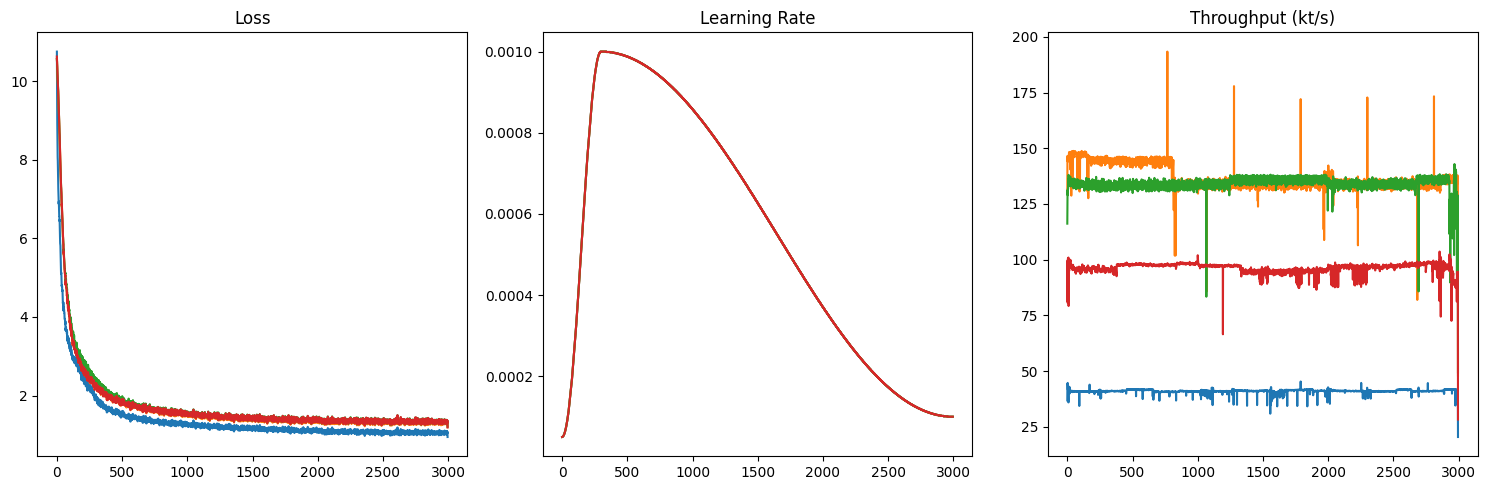

In [37]:
checkpoint_list = [
    # 'checkpoints/train-round1/checkpoint-19022/train_logs.pt',
    'checkpoints/tinystories-masked-train/checkpoint-done/train_logs.pt',
    'checkpoints/tinystories-masked-train-46M/checkpoint-done/train_logs.pt',
    'checkpoints/tinystories-no-mask-train-46M/checkpoint-done/train_logs.pt',
    'checkpoints/tinystories-no-mask-train-naive-46M/checkpoint-done/train_logs.pt',
]
logs_list = [torch.load(c) for c in checkpoint_list]

plot_train_logs(logs_list)

In [32]:
def generate(model, tokenizer, prompt, temperature, top_p, rep_penalty,
             max_new_tokens=20, total_tokens=None,
             end_tokens=None,
             enable_kv_cache=True):
    model.eval()

    feed_tokens = tokenizer.encode(prompt) if isinstance(prompt, str) else prompt
    all_tokens = feed_tokens.copy()
    if total_tokens is not None:
        max_new_tokens = max(0, total_tokens - len(feed_tokens))

    with torch.no_grad():
        kv_cache = None
        for _ in range(max_new_tokens):
            logits, kv_cache = model.forward(
                torch.tensor([feed_tokens if enable_kv_cache else all_tokens]).to(model.device),
                kv_cache=kv_cache)
            logits = logits[0][-1].cpu()
            if not enable_kv_cache:
                kv_cache = None

            # apply repetition penalty
            logits_rep = torch.gather(logits, 0, torch.tensor(all_tokens))
            logits_rep = torch.where(logits_rep < 0, logits_rep * rep_penalty, logits_rep / rep_penalty)
            logits.scatter_(0, torch.tensor(all_tokens), logits_rep)

            # apply temperature
            logits /= max(temperature, 1e-6)

            probs = torch.softmax(logits, dim=0)

            # apply top-p
            ordered_probs, ordered_indices = torch.sort(probs, descending=True)
            cum_probs = torch.cumsum(ordered_probs, dim=0).tolist()
            top_p_index = bisect.bisect_right(cum_probs, top_p) + 1
            ordered_probs, ordered_indices = ordered_probs[:top_p_index], ordered_indices[:top_p_index]
            sampled_index = ordered_indices[torch.multinomial(ordered_probs, num_samples=1).item()].item()

            all_tokens.append(sampled_index)
            feed_tokens = [sampled_index]

            if end_tokens is not None and sampled_index in end_tokens:
                break

    return all_tokens

In [33]:
def modeling_sanity_check(gen_length: int, enable_kv_cache: bool):
    assert C_DEBUG == True, 'sanity check can only be performed under debug settings'
    train_token_ids = next(iter(g_train_data))['token_ids'].tolist()
    train_texts = [l.strip() for l in g_tokenizer.decode(train_token_ids).split('</s>')]
    start_time = time.time()
    gen_token_ids = generate(g_model, g_tokenizer, train_token_ids[:10],
                             temperature=1.0, top_p=0.01, rep_penalty=1.0,
                             total_tokens=gen_length,
                             end_tokens=g_tokenizer.encode('<reserved_0>'),
                             enable_kv_cache=enable_kv_cache)
    cost_time = time.time() - start_time
    print(f'Generation finished in {cost_time:.2f} sec(s), throughput: {len(gen_token_ids) / cost_time:.1f} tokens/sec')
    # Complete check
    cmp_length = min(len(train_token_ids), len(gen_token_ids))
    print('Complete Identical:', train_token_ids[:cmp_length] == gen_token_ids[:cmp_length])
    # Segment check
    gen_texts = [l.strip() for l in g_tokenizer.decode(gen_token_ids).split('</s>')]
    for i in range(min(len(train_texts), len(gen_texts))):
        ref, real = train_texts[i], gen_texts[i]
        cmp_length = min(len(ref), len(real))
        print(f'Segment {i}: Ref Len: {len(ref)}, Gen Len: {len(real)} Identical: {ref[:cmp_length] == real[:cmp_length]}')

In [34]:
for backend_option in [AttentionBackend.Naive, AttentionBackend.FlashAttentionTriton, AttentionBackend.FlashAttentionCuda]:
    for enable_kv_cache_option in [True, False]:
        print(f'Backend = {backend_option}, KVCache Enable = {enable_kv_cache_option}')
        global_config['attn_backend'] = backend_option
        modeling_sanity_check(512, enable_kv_cache_option)
        print('=' * 80)

Backend = AttentionBackend.Naive, KVCache Enable = True


AssertionError: sanity check can only be performed under debug settings

In [35]:
for t in g_tokenizer.decode(next(iter(g_train_data))['token_ids'].tolist()).split('</s>')[:3]:
    print(t)

<s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!
<s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his friend, the 

In [36]:
time_start = time.time()
global_config['attn_backend'] = AttentionBackend.FlashAttentionCuda
result = generate(g_model, g_tokenizer, '<s>Alice was so tired when she got back home so she went',
                  temperature=1.0, top_p=0.01, rep_penalty=1.0,
                  total_tokens=128,
                  end_tokens=g_tokenizer.encode('</s>'),
                  enable_kv_cache=True)
time_cost = time.time() - time_start

print(g_tokenizer.decode(result))
print(f'{time_cost:.3f} sec(s), throughput {len(result) / time_cost:.1f} tokens/sec')

<s>Alice was so tired when she got back home so she went to bed. She was so tired that she couldn't sleep. She yawned and rubbed her eyes.
Alice's mom saw her and said, "What's wrong, Alice?"
Alice replied, "I'm so tired. I'm so tired."
Alice's mom smiled and said, "Let's go to the store and get some milk."
Alice and her mom went to the store and bought some milk. Alice was so happy and she drank
0.741 sec(s), throughput 172.8 tokens/sec


In [21]:
expand_attn_mask(torch.tensor(next(iter(g_train_data))['attn_mask'].astype(np.int32)).view(1, -1))

tensor([[[ True, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True, False, False],
         [False, False, False,  ...,  True,  True, False],
         [False, False, False,  ...,  True,  True,  True]]])